In [1]:
import pandas as pd
import numpy as np
import emoji
#emoji is a Python library for working with emojis.
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# ======================
# 1. Load and Prepare Data
# ======================

# Load datasets
train_data = pd.read_csv('train_emoji.csv', header=None)
test_data = pd.read_csv('test_emoji.csv', header=None)

# Clean data
train_data.drop(columns=[2,3], inplace=True)
test_data.drop(columns=[2], inplace=True, errors='ignore')

# Emoji mapping
emoji_dict = {
    0: ':red_heart:',
    1: ':baseball:',
    2: ':face_with_tears_of_joy:',
    3: ':confounded_face:',
    4: ':fork_and_knife:'
}


In [3]:
# ======================
# 2. Text Processing
# ======================

# Load GloVe embeddings
embedding_matrix = {}
with open('glove.6B.50d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embedding_matrix[word] = vector

def text_to_embeddings(texts, max_len=10):
    """Convert texts to embedding matrices"""
    embeddings = np.zeros((len(texts), max_len, 50))
    for i, text in enumerate(texts):
        words = text.lower().split()[:max_len]
        for j, word in enumerate(words):
            if word in embedding_matrix:
                embeddings[i][j] = embedding_matrix[word]
    return embeddings

# Prepare data
X_train = text_to_embeddings(train_data[0])
y_train = to_categorical(train_data[1])
X_test = text_to_embeddings(test_data[0])
y_test = to_categorical(test_data[1])


In [4]:
# ======================
# 3. Model Training
# ======================

model = Sequential([
    LSTM(64, input_shape=(10, 50), return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                   validation_data=(X_test, y_test),
                   epochs=50, 
                   batch_size=32)

C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.1703 - loss: 1.6055 - val_accuracy: 0.2857 - val_loss: 1.5506
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3219 - loss: 1.5237 - val_accuracy: 0.2857 - val_loss: 1.5265
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2873 - loss: 1.5290 - val_accuracy: 0.3929 - val_loss: 1.4795
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3554 - loss: 1.4480 - val_accuracy: 0.4286 - val_loss: 1.4283
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3996 - loss: 1.3693 - val_accuracy: 0.4107 - val_loss: 1.3858
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3940 - loss: 1.3324 - val_accuracy: 0.4286 - val_loss: 1.3165
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5638 - loss: 1.1937 - val_accuracy: 0.5357 - val_loss: 1.2596
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5800 - loss: 1.1243 - val_accuracy: 0.5179 - val_loss: 1.1968


Training Accuracy: 100.00%
Test Accuracy: 60.71%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step

Classification Report:
                          precision    recall  f1-score   support

             :red_heart:       0.56      0.42      0.48        12
              :baseball:       0.62      1.00      0.77         5
:face_with_tears_of_joy:       0.69      0.50      0.58        18
       :confounded_face:       0.47      0.60      0.53        15
        :fork_and_knife:       0.86      1.00      0.92         6

                accuracy                           0.61        56
               macro avg       0.64      0.70      0.66        56
            weighted avg       0.62      0.61      0.60        56



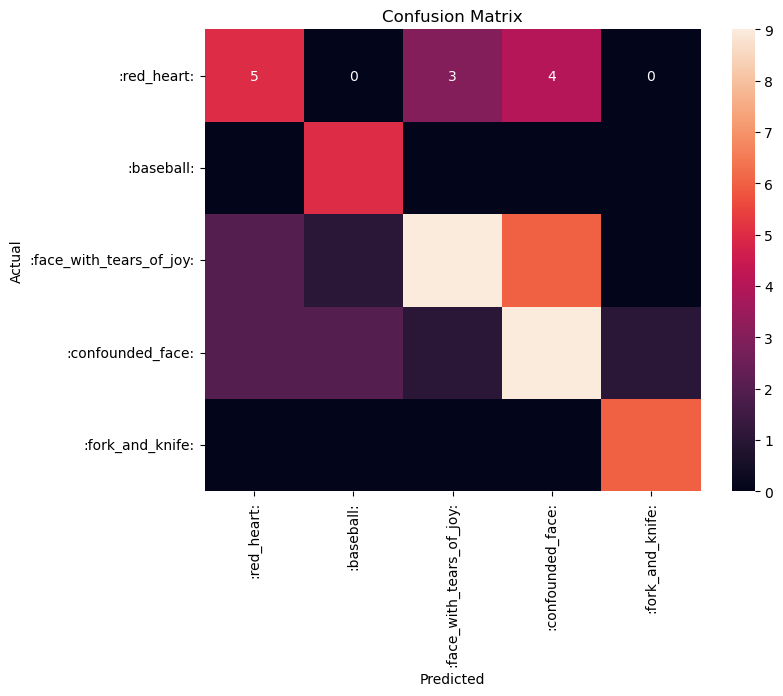

In [5]:
# ======================
# 4. Evaluate Performance
# ======================

def evaluate_model():
    # Training accuracy
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    print(f"\nTraining Accuracy: {train_acc*100:.2f}%")
    
    # Test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    
    # Classification report
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=list(emoji_dict.values())))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=emoji_dict.values(),
                yticklabels=emoji_dict.values())
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

evaluate_model()

In [6]:
# ======================
# 5. Prediction Function
# ======================

def predict_emoji(text):
    """Predict emoji for custom text input"""
    # Process input text
    embedding = text_to_embeddings([text])
    
    # Make prediction
    prediction = model.predict(embedding)
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    # Get emoji
    pred_emoji = emoji.emojize(emoji_dict[pred_class])
    
    print(f"\nInput: '{text}'")
    print(f"Predicted: {pred_emoji} (Confidence: {confidence*100:.1f}%)")
    
    # Show all probabilities
    print("\nAll probabilities:")
    for i, prob in enumerate(prediction[0]):
        print(f"{emoji.emojize(emoji_dict[i])}: {prob*100:.1f}%")


In [ ]:
# ======================
# 6. Interactive Prediction
# ======================

print("\nType 'quit' to exit")
while True:
    user_input = input("\nEnter text to predict emoji: ")
    if user_input.lower() == 'quit':
        break
    predict_emoji(user_input)

# Save model
model.save('emoji_predictor.h5')
print("\nModel saved as 'emoji_predictor.h5'")


Type 'quit' to exit



Enter text to predict emoji:  i love sweets


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Input: 'i love sweets'
Predicted: 😂 (Confidence: 96.8%)

All probabilities:
❤️: 2.7%
⚾: 0.0%
😂: 96.8%
😖: 0.0%
🍴: 0.4%



Enter text to predict emoji:  i love sweets not


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Input: 'i love sweets not'
Predicted: 😂 (Confidence: 97.2%)

All probabilities:
❤️: 2.4%
⚾: 0.0%
😂: 97.2%
😖: 0.0%
🍴: 0.3%



Enter text to predict emoji:  i do not like sweet


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Input: 'i do not like sweet'
Predicted: ❤️ (Confidence: 93.7%)

All probabilities:
❤️: 93.7%
⚾: 0.0%
😂: 4.8%
😖: 0.2%
🍴: 1.2%
